# Gender Pay Gap

Team members: 
* Jordan Farrell 
* Julio Oliveira 
* Ashwath Ramesh 
* Satoshi Taniguchi 
* Junjun Tao 
* William Teodecki 

In [164]:
import pickle
import pandas as pd

from fitter import Fitter
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split


import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [124]:
psid = pd.read_csv('../data/external/PanelStudyIncomeDynamics.csv')


In [125]:
psid.head()

intnum68  pernum68  wave  sex  intnum  farminc  region  famwgt  relhead  \
0      1152        24  1981    1    3505      0.0     1.0  17.000       10   
1      5057       171  1981    1     675      0.0     2.0   2.000       10   
2      6375       170  2009    1    8505      0.0     1.0   6.565       10   
3      2261         3  1999    1    4202      0.0     2.0  25.973       10   
4      5927         7  1990    1     605      0.0     3.0  14.819       10   

   age  ...  foodcare  building  sales  officeadmin  farmer  \
0   34  ...         0         0      1            0       0   
1   32  ...         0         0      0            0       0   
2   64  ...         0         0      0            0       0   
3   50  ...         0         0      0            0       0   
4   26  ...         0         0      0            0       0   

   constructextractinstall  production  transport  sumocc  LEHS  
0                        0           0          0       1     0  
1                        0           1          0       1     1  
2                        0           1          0       1     1  
3                        0           0          1       1     1  
4                        0           1          0       1     1  

[5 rows x 274 columns]

In [126]:
psid.shape

(33398, 274)

### Income Columns

In [127]:
income_cols = ['farminc','annlabinc','labincbus', 'annhrs','hrwage']
psid[income_cols].describe()

farminc     annlabinc     labincbus        annhrs        hrwage
count   33398.000000  3.339800e+04  33398.000000  33398.000000  33398.000000
mean      104.879544  3.708689e+04    168.051859   1990.103449     18.418722
std      2662.001098  4.156487e+04   2257.977695    623.592732     19.462814
min     -5000.000000  3.000000e+01      0.000000     10.000000      0.891473
25%         0.000000  1.600000e+04      0.000000   1767.000000      8.823529
50%         0.000000  2.900000e+04      0.000000   2000.000000     14.423077
75%         0.000000  4.600000e+04      0.000000   2277.000000     22.373541
max    200000.000000  1.500000e+06  99999.000000   5840.000000   1000.000000

Looking into anomalous values in income we were able to find the farm incomes can be negative.

In [128]:
psid[psid['farminc'] != 0][income_cols].describe()

farminc      annlabinc     labincbus       annhrs      hrwage
count     120.000000     120.000000    120.000000   120.000000  120.000000
mean    29189.725000   24491.858333    114.133333  1860.741667   12.721140
std     33654.453819   18135.461596    933.531183   668.718635    7.682096
min     -5000.000000     400.000000      0.000000   129.000000    2.334267
25%      7000.000000   10748.750000      0.000000  1470.000000    7.179206
50%     20000.000000   21000.000000      0.000000  2000.000000   10.971956
75%     40250.000000   33325.000000      0.000000  2173.250000   16.811773
max    200000.000000  101400.000000  10000.000000  3491.000000   41.666668

100% of the dataset has annual labor income greater than 0.

In [129]:
psid[psid.annlabinc > 0].shape[0] / psid.shape[0] 

1.0

### Categorical columns

In [130]:
category_cols = ['sex','region','white', 'black','hisp', 'age','degree','yrsexp','yrsftexp','yrsptexp']

There is no considerable amount of missing values for the main attributes.

In [131]:
psid[category_cols].isnull().sum()

sex          0
region       3
white        0
black        0
hisp         0
age          0
degree      40
yrsexp       0
yrsftexp     0
yrsptexp     0
dtype: int64

### Classes distribution

See dataset description for more details: https://github.com/jcalvesoliveira/gender-pay-gap/blob/master/docs/datasets/PanelStudyIncomeDynamics.names

#### Distribution of labor income

sumsquare_error           aic           bic  kl_div
chi2        1.402789e-11   8022.927868 -1.182466e+06     inf
expon       8.829477e-11   6155.790778 -1.121036e+06     inf
norm        2.396454e-10  42587.165871 -1.087689e+06     inf
lognorm     7.046555e-10   3425.914448 -1.051657e+06     inf

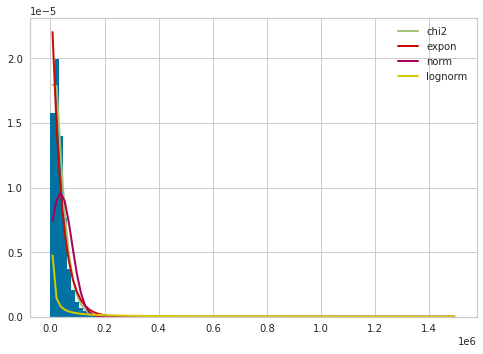

In [132]:
f = Fitter(psid.annlabinc,
           distributions=['lognorm',
                          "norm", "expon","chi2"])
f.fit()
f.summary()

The labor income distribution is skewed to the right, meaning that a small amount of people will make a lot of money. In order to focus our analysis in the overall population we filter out the 10% highest incomes by selecting the 90th percentile.

In [133]:
q_9 = psid.annlabinc.quantile(0.99)
q_9

171000.0

### What categorical features may have an effect on income?

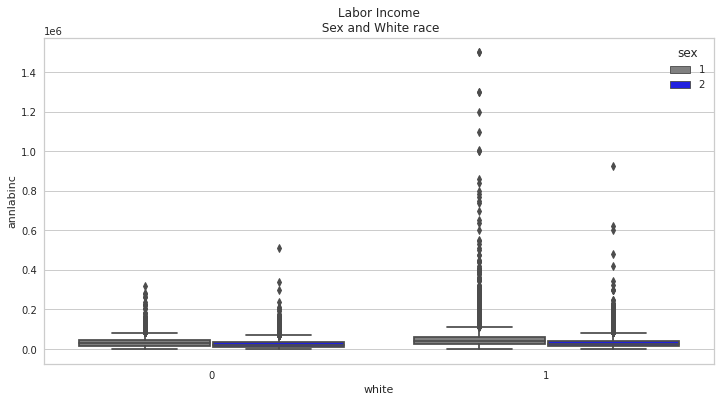

In [134]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(title="Labor Income\n Sex and White race")
ax = sns.boxplot(x="white", y="annlabinc", hue="sex",
                 data=psid, 
                 dodge=True, ax = ax, palette=['gray','blue'])

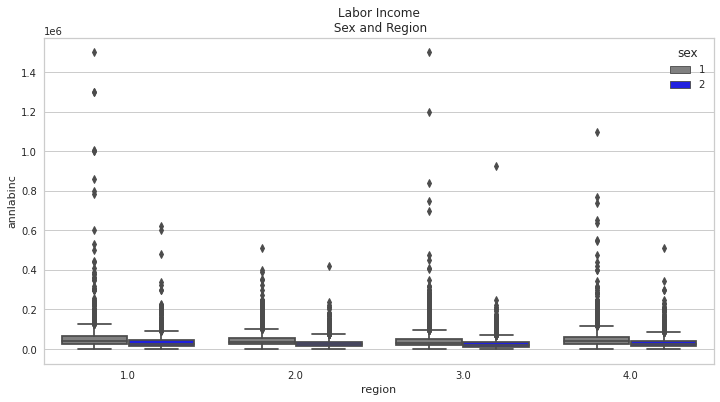

In [135]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(title="Labor Income\n Sex and Region")
ax = sns.boxplot(x="region", y="annlabinc", hue="sex",
                 data=psid, 
                 dodge=True, ax = ax, palette=['gray','blue'])

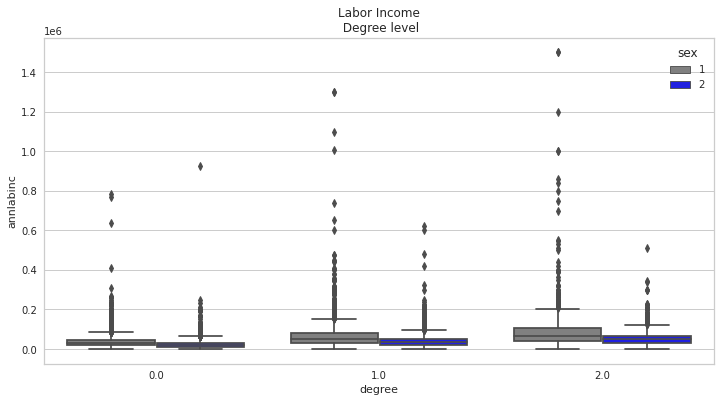

In [136]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(title="Labor Income\n Degree level")
ax = sns.boxplot(x="degree", y="annlabinc", hue="sex",
                 data=psid, 
                 dodge=True, ax = ax, palette=['gray','blue'])

## Data Cleaning

In [137]:
psid = psid[category_cols + income_cols]    
psid = psid[psid.annlabinc < q_9]
psid.degree.fillna(0, inplace=True)
psid = psid[psid['region'].notna()]

In [138]:
psid.to_csv('../data/processed/psid.csv')

### What categorical features may have an effect on income?

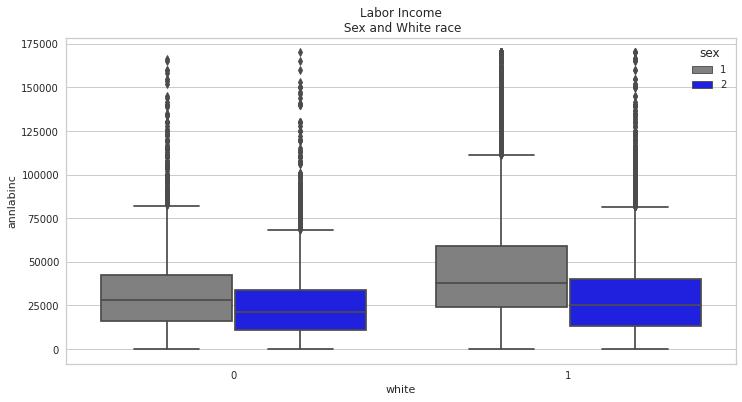

In [139]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(title="Labor Income\n Sex and White race")
ax = sns.boxplot(x="white", y="annlabinc", hue="sex",
                 data=psid, 
                 dodge=True, ax = ax, palette=['gray','blue'])

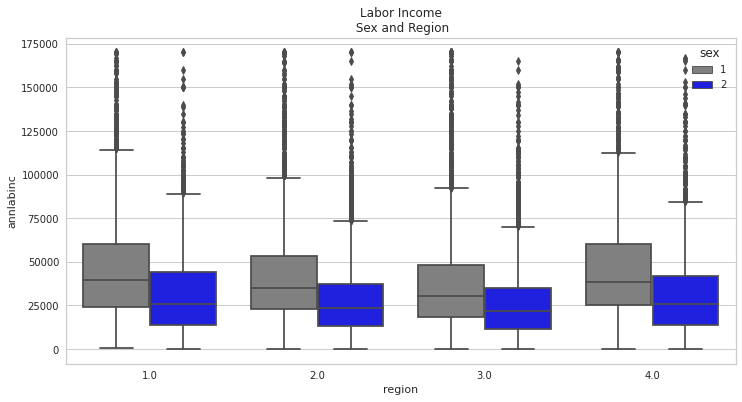

In [140]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(title="Labor Income\n Sex and Region")
ax = sns.boxplot(x="region", y="annlabinc", hue="sex",
                 data=psid, 
                 dodge=True, ax = ax, palette=['gray','blue'])

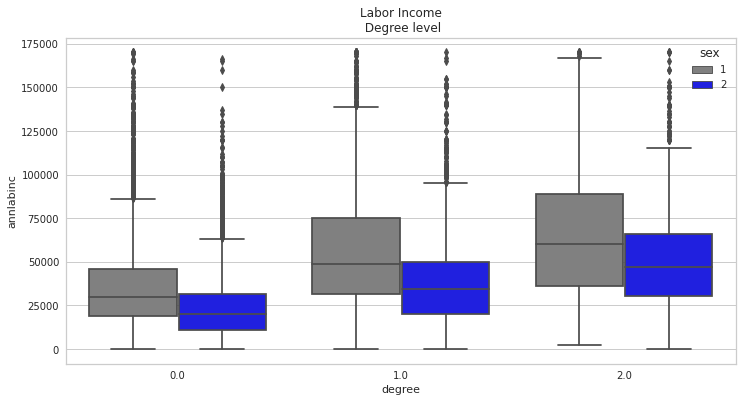

In [141]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(title="Labor Income\n Degree level")
ax = sns.boxplot(x="degree", y="annlabinc", hue="sex",
                 data=psid, 
                 dodge=True, ax = ax, palette=['gray','blue'])

Looking into the plot below, we can observe that different from what we would expect we could not identify a clear relationship between age and years of experience with labor income.

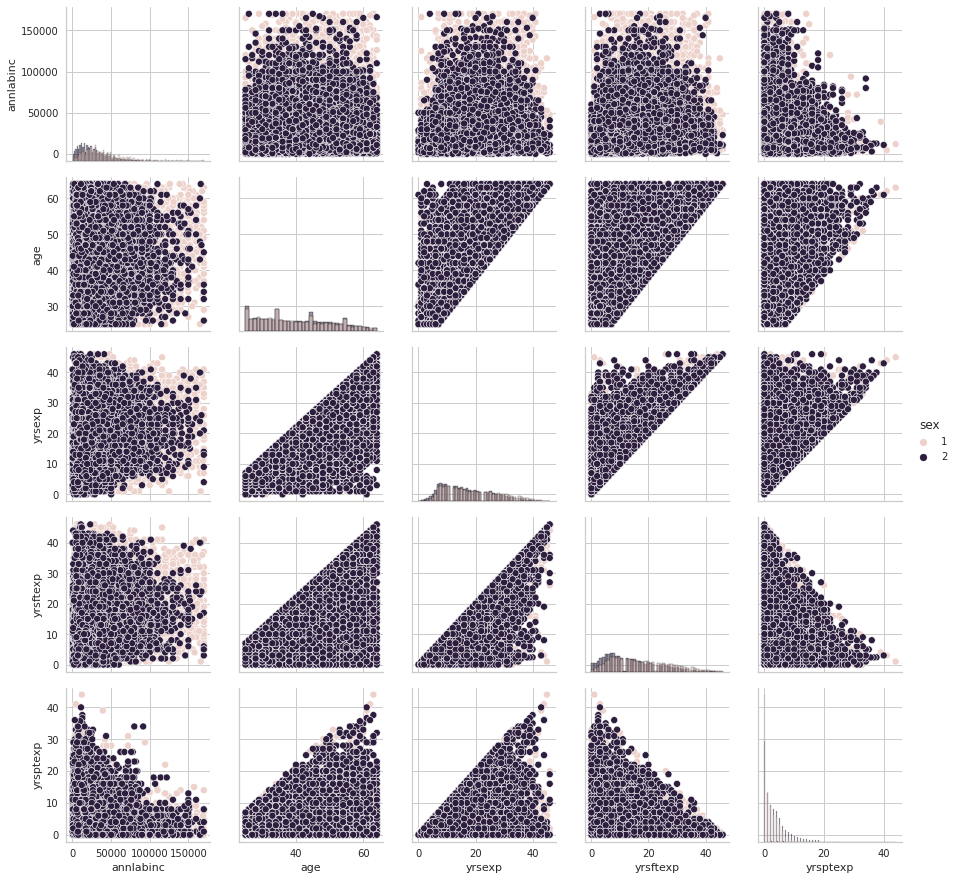

In [142]:
g = sns.PairGrid(psid[['annlabinc','age','sex','yrsexp','yrsftexp','yrsptexp']], hue="sex")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

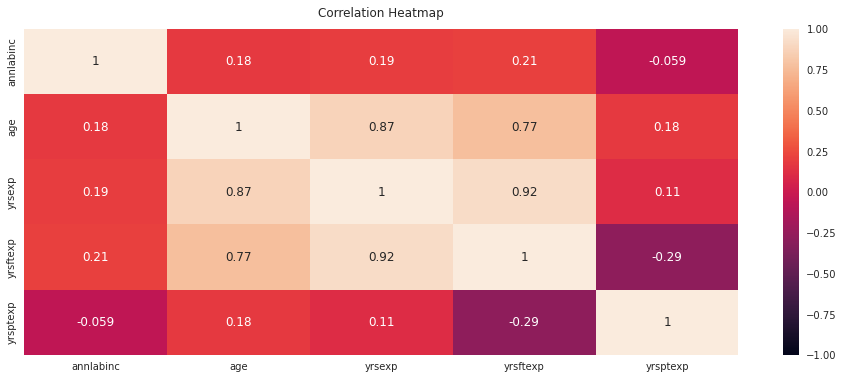

In [143]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(psid[psid.annlabinc < q_9][['annlabinc','age','yrsexp','yrsftexp','yrsptexp']].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Data Transformation

In [159]:
X = pd.read_csv('../data/processed/psid_preprocessed.csv')
X.head()

sex  age  annhrs  annlabinc  degree  yrsexp  yrsftexp  yrsptexp     hrwage  \
0    1   34    1600    10000.0     1.0    12.0      12.0       0.0   6.250000   
1    1   64    2550    45200.0     0.0    39.0      38.0       1.0  17.725491   
2    1   26    2100    24500.0     0.0     8.0       8.0       0.0  11.666667   
3    1   39    1944    46500.0     2.0    15.0       6.0       9.0  23.919754   
4    1   40    2024    60000.0     0.0    17.0      16.0       1.0  29.644268   

   race  job  region  
0     2   17       1  
1     0   15       1  
2     2   15       2  
3     2    8       1  
4     2    5       1

In [160]:
# ENCODED_WEIGHT = 0.2
# SEX_WEIGHT = 2
cat_cols = ['sex','degree','race', 'job', 'region']
ohe = OneHotEncoder(drop='first')
encoded = ohe.fit_transform(X[cat_cols])
encoded = pd.DataFrame(encoded.todense(), columns=ohe.get_feature_names_out())
# encoded = encoded * ENCODED_WEIGHT
# encoded.sex_2 = encoded.sex_2 * SEX_WEIGHT
X.drop(cat_cols, axis=1, inplace=True)

In [161]:
num_cols = X.columns
normalized = MinMaxScaler().fit_transform(X)
normalized = pd.DataFrame(normalized, columns=num_cols)

In [162]:
X = pd.concat([normalized, encoded], axis=1)
X.drop(['annlabinc','yrsftexp', 'yrsptexp',], axis=1, inplace=True)

In [163]:
X

age    annhrs    yrsexp    hrwage  sex_2  degree_1.0  degree_2.0  \
0      0.230769  0.310114  0.266667  0.154472    0.0         1.0         0.0   
1      1.000000  0.800310  0.866667  0.485366    0.0         0.0         0.0   
2      0.025641  0.568111  0.177778  0.310661    0.0         0.0         0.0   
3      0.358974  0.487616  0.333333  0.663977    0.0         0.0         1.0   
4      0.384615  0.528896  0.377778  0.829042    0.0         0.0         0.0   
...         ...       ...       ...       ...    ...         ...         ...   
24584  0.230769  0.779670  0.355556  0.399310    1.0         1.0         0.0   
24585  0.743590  0.392673  0.777778  0.337934    1.0         0.0         0.0   
24586  0.205128  0.500000  0.066667  0.083968    1.0         0.0         0.0   
24587  0.000000  0.541280  0.133333  0.227686    1.0         0.0         0.0   
24588  0.128205  0.383385  0.088889  0.090124    1.0         0.0         0.0   

       race_1  race_2  job_1  ...  job_14  job_15  job_16  job_17  job_18  \
0         0.0     1.0    0.0  ...     0.0     0.0     0.0     1.0     0.0   
1         0.0     0.0    0.0  ...     0.0     1.0     0.0     0.0     0.0   
2         0.0     1.0    0.0  ...     0.0     1.0     0.0     0.0     0.0   
3         0.0     1.0    0.0  ...     0.0     0.0     0.0     0.0     0.0   
4         0.0     1.0    0.0  ...     0.0     0.0     0.0     0.0     0.0   
...       ...     ...    ...  ...     ...     ...     ...     ...     ...   
24584     0.0     1.0    0.0  ...     0.0     0.0     0.0     0.0     0.0   
24585     0.0     1.0    0.0  ...     0.0     0.0     0.0     0.0     0.0   
24586     0.0     0.0    0.0  ...     0.0     0.0     0.0     0.0     0.0   
24587     0.0     0.0    0.0  ...     0.0     0.0     0.0     0.0     0.0   
24588     0.0     1.0    0.0  ...     0.0     0.0     0.0     0.0     0.0   

       job_19  job_20  region_1  region_2  region_3  
0         0.0     0.0       1.0       0.0       0.0  
1         0.0     0.0       1.0       0.0       0.0  
2         0.0     0.0       0.0       1.0       0.0  
3         0.0     0.0       1.0       0.0       0.0  
4         0.0     0.0       1.0       0.0       0.0  
...       ...     ...       ...       ...       ...  
24584     0.0     0.0       1.0       0.0       0.0  
24585     0.0     0.0       0.0       0.0       0.0  
24586     0.0     0.0       0.0       1.0       0.0  
24587     0.0     0.0       0.0       1.0       0.0  
24588     0.0     0.0       0.0       0.0       1.0  

[24589 rows x 32 columns]

In [149]:
pca = PCA()
components = pca.fit_transform(X)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=X["sex_2"],
)
fig.update_traces(diagonal_visible=False)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()

## Modeling

## Clustering

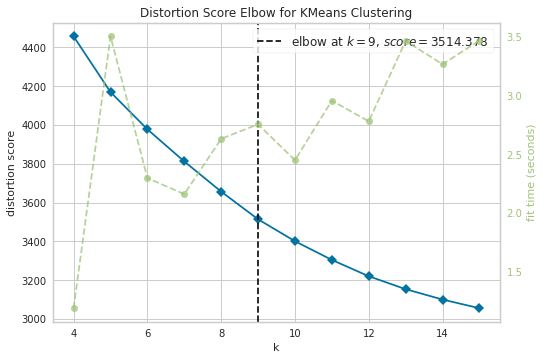

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [151]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(4,16))
elbow.fit(X)
elbow.show()

In [152]:
# Uncoment the lines below for retraining the model. 

kmeans = KMeans(elbow.elbow_value_)
kmeans.fit(components)

with open('../models/kmeans.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

with open('../models/kmeans.pkl', 'rb') as file:
    kmeans = pickle.load(file)

In [153]:
X['cluster'] = kmeans.predict(X)
cluster_counts = X.cluster.value_counts().sort_index()
cluster_counts

/home/julio/.local/share/virtualenvs/gender-pay-gap-VcKyyecI/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but KMeans was fitted without feature names



0    13710
3       50
4       77
5      316
6     8811
7     1350
8      275
Name: cluster, dtype: int64

In [154]:
MIN_LEN = 50

clusters_filter = {i for i,value in enumerate(cluster_counts) if value > MIN_LEN}
clusters_filter
X = X[X.cluster.isin(clusters_filter)]

In [155]:
male_proportion = X.groupby('cluster')['sex_2'].sum() / X.groupby('cluster')['sex_2'].count()
male_cluster = set(male_proportion[male_proportion >= 0.7].index)
female_cluster = set(male_proportion[male_proportion <= 0.3].index)
X['cluster_type'] = X.cluster.apply(lambda x: 'man' if x in male_cluster else 'woman' if x in female_cluster else 'mixed')
male_proportion

/tmp/ipykernel_16256/4038419617.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cluster
0    0.219694
3    0.360000
4    0.280519
5    0.312658
6    0.177914
Name: sex_2, dtype: float64

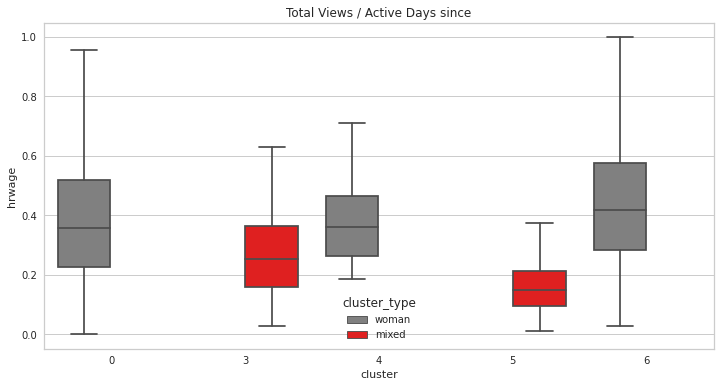

In [156]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlabel="Total Views",
       ylabel="Active Days Since",
       title="Total Views / Active Days since")

ax = sns.boxplot(x="cluster", y="hrwage",hue="cluster_type",
                 data=X, ax = ax, palette=['gray','red','blue'], showfliers=False)

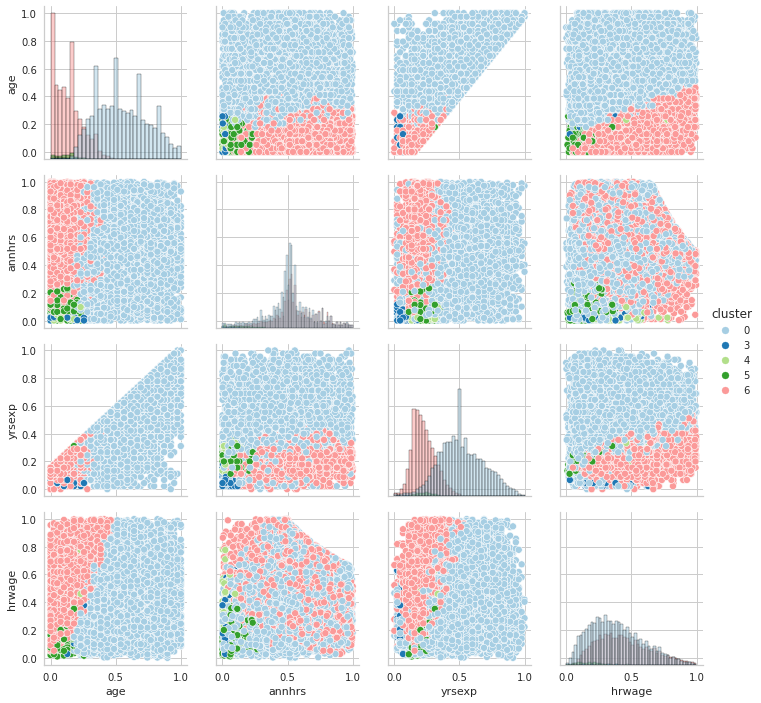

In [157]:
# cols_to_plot = ['age', 'annhrs', 'yrsexp', 'hrwage', 'sex_1',
#        'degree_0.0', 'degree_1.0', 'degree_2.0', 'race_0', 'race_1',
#        'race_2', 'region_0', 'region_1', 'region_2', 'region_3', 'cluster']

cols_to_plot = ['age', 'annhrs', 'yrsexp', 'hrwage','cluster']
# cols_to_plot = ['hrwage','region_0', 'region_1', 'region_2', 'region_3','cluster']

g = sns.PairGrid(X[cols_to_plot][~X['cluster'].isin(male_cluster)], hue="cluster", palette="Paired")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()